In [92]:
%matplotlib inline
from bigbang.archive import Archive
from bigbang import repo_loader;
from bigbang.git_repo import GitRepo;
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import random

from networkx.readwrite import json_graph
import json

# Loading Our MultiRepo
A MultiRepo is an object that contains commit data from multiple GitRepo objects. We create this with a special function in the repo_loader class. The name provided must be the exact name of the organization on Github.

Please note that many Github organizations have many projects with many commits, and bigbang takes about 1 minute per 3000 commits. Also, if you have a slow internet connection, the API calls to github may freeze. Loading from the edX organization takes about 5 to 10 minutes. Make sure it isn't frozen!

In [93]:
org_name = "dlab-berkeley"
repo = repo_loader.get_org_multirepo(org_name)
full_info = repo.commit_data
handled = pd.DataFrame(full_info.groupby(["Repo Name", "Committer Name"]).size())
repo_size_df = pd.DataFrame(full_info.groupby("Repo Name").size())
author_commits_df = pd.DataFrame(full_info.groupby("Committer Name").size())

## Author / File Graph
The graph below is a bi-partite graph. There are two types of nodes: committers, and files. Each committer will be connected to a file if they have edited that file. The edge weight represents how many times that committer has edited that file.
Feel free to skip this, as you'll see, the data is impossible to comprehend. There are way too many sample points and connections. It will take around 5 minutes just to gather the data.

In [94]:
G = nx.Graph()
full_info = repo.commit_data
repo_colors = dict() # Repo name -> (r, g, b)

# Author -> File
def make_graph(row):
    repo_name = row["Repo Name"]
    committer_name = row["Committer Name"]
    files = row["Touched File"]
    if repo_name not in repo_colors:
        repo_colors[repo_name] = (random.randrange(255), random.randrange(255), random.randrange(255))
    
    if committer_name not in G:
        s = ((author_commits_df.loc[committer_name])[0])
        G.add_node(committer_name, type="committer", size=s)
    
    for f in files:
        if f not in G:
            G.add_node(f, color="blue", type="file", repo=repo_name)

        if f not in G[committer_name]:
            G.add_edge(committer_name, f, weight=0)

        G[committer_name][f]["weight"] += 1;
        
    return row
    
full_info = full_info.apply(make_graph, axis=1)
json.dump(json_graph.node_link_data(G), open("./viz/git/" + str(org_name) + "_author2file.json", "w"))

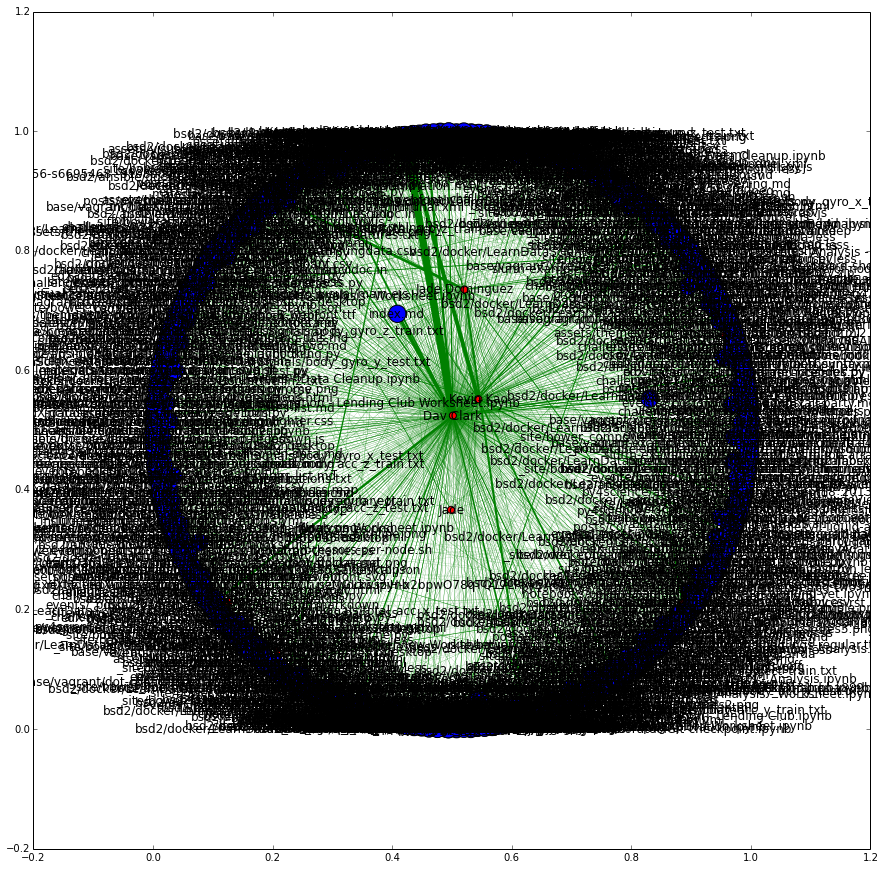

In [95]:
widths = [G[u][v]['weight']/10.0 for u, v in G.edges()]
#nx.draw(G)
plt.figure(1,figsize=(15, 15))
pos = nx.spring_layout(G, k = 0.6, iterations = 50)
nx.draw_networkx_nodes(G, pos, nodelist = [node[0] for node in G.nodes(data=True) if node[1]["type"] == 'committer'], node_size=50, node_color = 'r')
nx.draw_networkx_nodes(G, pos, nodelist = [node[0] for node in G.nodes(data=True) if node[1]["type"] == 'file'], node_color = 'b')
#nx.draw_networkx_edges(G, pos, edge_color = 'g', alpha = 0.8)
nx.draw_networkx_edges(G, pos, width=widths, edge_color = "g")
nx.draw_networkx_labels(G, pos);


## Author / Repo Graph

Let's merge the nodes a little bit to make our lives easier. We don't care that much about individual files, but more so the repos that they belong to.

The graph below is a bi-partite graph. There are two types of nodes: committers, and repos. Each committer will be connected to a repo if they have edited a file in that repo. The edge weight represents how many times that committer has editted a file in that repo.

We expect a few authors to connect to more than one repo, because they might work across projects within their organization.


In [96]:
G = nx.Graph()
handled = pd.DataFrame(full_info.groupby(["Repo Name", "Committer Name"]).size())

# Author -> Repo
def make_graph(row):
    repo_name = row.name[0]
    committer_name = row.name[1]
    count = row[0]
    
    if committer_name not in G:
        s = ((author_commits_df.loc[committer_name])[0])
        G.add_node(committer_name, type="committer", size=s)
        
    if repo_name not in G:
        s = ((repo_size_df.loc[repo_name])[0])
        G.add_node(repo_name, color="blue", type="repo", size=s)
    
    if repo_name not in G[committer_name]:
        G.add_edge(committer_name, repo_name, weight=0)
        
    G[committer_name][repo_name]["weight"] += count;
        
    return row
    
handled = handled.apply(make_graph, axis=1)
json.dump(json_graph.node_link_data(G), open("./viz/git/" + str(org_name) + "_author2repo.json", "w"))

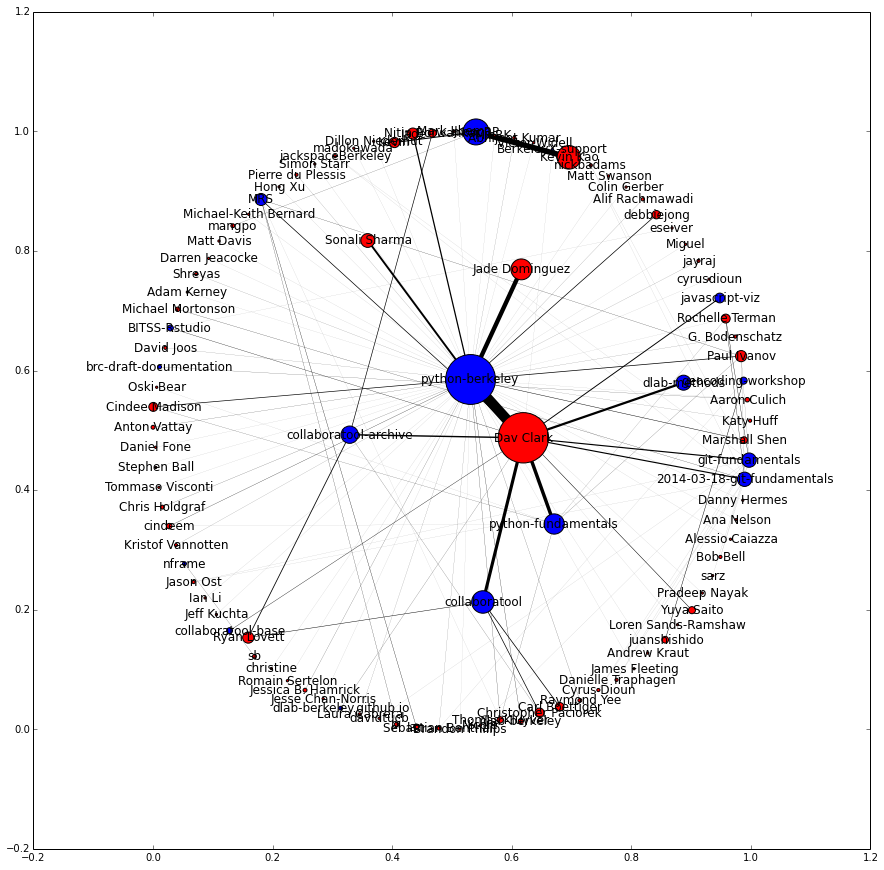

In [102]:
widths = [G[u][v]['weight']/20.0 for u, v in G.edges()]
c_sizes = [node[1]["size"]*5 for node in G.nodes(data=True) if node[1]["type"] == 'committer']
r_sizes = [node[1]["size"]*5 for node in G.nodes(data=True) if node[1]["type"] == 'repo']

#nx.draw(G)
plt.figure(1,figsize=(15, 15))
pos = nx.spring_layout(G, k = 0.6, iterations = 50)
nx.draw_networkx_nodes(G, pos, nodelist = [node[0] for node in G.nodes(data=True) if node[1]["type"] == 'committer'], node_size=c_sizes, node_color = 'r')
nx.draw_networkx_nodes(G, pos, nodelist = [node[0] for node in G.nodes(data=True) if node[1]["type"] == 'repo'], node_size=r_sizes, node_color = 'b')
#nx.draw_networkx_edges(G, pos, edge_color = 'g', alpha = 0.8)
nx.draw_networkx_edges(G, pos, width=widths)
nx.draw_networkx_labels(G, pos);

## Repo / Repo Graph
The above graph might still be way too cluttered for us to gain any insight, especially with large organizations. What we really want is to see how socially connected two repos are. In this case, we don't really care about specific committers. So we are going to consolidate our Committer-Repo graph's information into a Repo-Repo Graph. We want the weight of the edge between two repo nodes to represent, in some way, how "socially connected" they are. If they have a lot of committers that make a lot of edits to both repos, then the weight between them should be more. This is kind of tricky to do quantitatively, but this is going to be our method:

For each pair of nodes, n1 and n2, the edge weight between them will be the sum of the "common-ness" of their common authors. For a given author that has committed to n1 3 times and n2 5 times, for example, the "common-ness" will be the minimum least value of 3 and 5. Therefore, for that common author, we will add 3 to the edge weight between n1 and n2. We repeat this process for all common authors between n1 and n2, and for all other pairs of nodes as well.



In [98]:
repos = [node[0] for node in G.nodes(data=True) if node[1]["type"] == 'repo']
committers = [node[0] for node in G.nodes(data=True) if node[1]["type"] == 'committer']

# Repo -> Repo
NG = nx.Graph()
for u,v in G.edges():
    committer = v
    repo = u
    if u in committers:
        committer = u
        repo = v
    if repo not in NG:
        NG.add_node(repo, type="repo");
    
    for other_repo in repos:
        if other_repo not in NG:
            NG.add_node(other_repo, type="repo");
        if other_repo != repo:
            if committer in G[other_repo]:
                to_add = min(G[repo][committer]["weight"], G[other_repo][committer]["weight"])
                
                if other_repo not in NG[repo]:
                    NG.add_edge(repo, other_repo, weight=0);
                
                NG[repo][other_repo]["weight"] += to_add;


    
    

In [99]:
json.dump(json_graph.node_link_data(NG), open("./viz/git/" + str(org_name) + "_repo2repo.json", "w"))

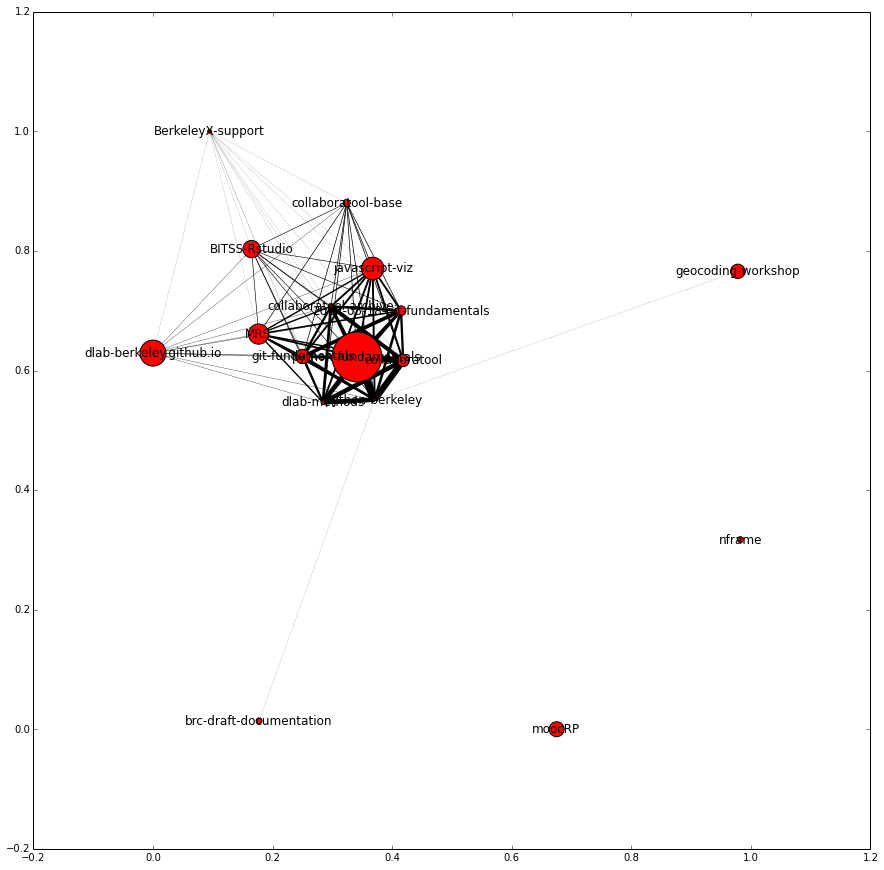

In [101]:
widths = [NG[u][v]['weight']/20.0  for u, v in NG.edges()]
r_sizes = [node[1]["size"]*5 for node in G.nodes(data=True) if node[1]["type"] == 'repo']

plt.figure(1,figsize=(15, 15))
pos = nx.spring_layout(NG, k = 0.6, iterations = 100)
nx.draw_networkx_nodes(NG, pos, nodelist = [node[0] for node in NG.nodes(data=True)], node_size=r_sizes, node_color = 'r')
nx.draw_networkx_edges(NG, pos, width=widths)
nx.draw_networkx_labels(NG, pos);